we start with 3204769 transcripts, only 532080 transcripts that were assigned to our polygons
from xenium we know that they detected 216323 cells, we detected 147344 or 83947 after processing (including filtering of 4489, because polygon was not uniquely mapped to a cell)

In [1]:
import sys
sys.path.append('utils')
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd

from stardist.models import StarDist2D

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2024-09-01 18:53:08.273223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gdf = gpd.read_file('../data/xenium/stardist_buffered_07.geojson')
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]
gdf.crs = None
gdf

id                                           geometry
0            ID_1  POLYGON ((2064.585 346.259, 2064.443 347.150, ...
1            ID_2  POLYGON ((2948.857 2708.953, 2948.857 2708.953...
2            ID_3  POLYGON ((2913.311 3155.884, 2913.176 3156.081...
3            ID_4  POLYGON ((3070.291 3509.373, 3070.743 3508.136...
4            ID_5  POLYGON ((2971.103 3292.006, 2970.909 3292.596...
...           ...                                                ...
216348  ID_216349  POLYGON ((27885.864 21588.620, 27885.866 21588...
216349  ID_216350  POLYGON ((28879.943 21223.216, 28879.438 21223...
216350  ID_216351  POLYGON ((27610.110 20999.249, 27609.944 20999...
216351  ID_216352  POLYGON ((28838.589 20801.128, 28838.483 20801...
216352  ID_216353  POLYGON ((28713.604 22061.967, 28713.751 22062...

[216353 rows x 2 columns]

In [3]:
import scanpy as sc
adata = sc.read_h5ad('../data/xenium/outs/transcripts_anndata_final.h5ad')
adata

AnnData object with n_obs × n_vars = 3204769 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [4]:
adata_df = adata.to_df()

In [5]:
df_tissue_positions = adata_df
df_tissue_positions['index']=df_tissue_positions.index

In [6]:
# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(adata.obs['center_x'], adata.obs['center_y'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)

In [7]:
gdf.crs = None

In [8]:
result_spatial_join = gpd.sjoin(gdf_coordinates, gdf, how='left', predicate='within')

In [9]:
# Identify nuclei associated barcodes and find barcodes that are in more than one nucleus
result_spatial_join['is_within_polygon'] = ~result_spatial_join['index_right'].isna()

In [10]:
# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon']==True]


In [11]:
barcodes_in_one_polygon.shape

(9711909, 546)

In [12]:
# Convert the tuples in barcodes_in_one_polygon['index'] to strings
barcodes_in_one_polygon['index'] = barcodes_in_one_polygon['index'].apply(lambda x: str(x))

# If you want to remove the 'bin' index name and set it as a regular column
barcodes_in_one_polygon.reset_index(inplace=True, drop=True)

geodataframe.py (1528): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
barcodes_in_overlaping_polygons = pd.unique(result_spatial_join[result_spatial_join.duplicated(subset=['index'])]['index'])
result_spatial_join['is_not_in_an_polygon_overlap'] = ~result_spatial_join['index'].isin(barcodes_in_overlaping_polygons)

# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon'] & result_spatial_join['is_not_in_an_polygon_overlap']]

In [14]:
# The AnnData object is filtered to only contain the barcodes that are in non-overlapping polygon regions
filtered_obs_mask = adata.obs_names.isin(barcodes_in_one_polygon['index'])

In [15]:
filtered_adata = adata[filtered_obs_mask,:]

In [16]:
filtered_adata

View of AnnData object with n_obs × n_vars = 502749 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [17]:
print(f"Length of filtered_adata.obs: {len(filtered_adata.obs)}")
print(f"Length of barcodes_in_one_polygon: {len(barcodes_in_one_polygon)}")

Length of filtered_adata.obs: 502749
Length of barcodes_in_one_polygon: 502749


In [18]:
print(filtered_adata.obs.index[:5])  # Print first few indices from filtered_adata.obs
print(barcodes_in_one_polygon['index'][:5])  # Print first few indices from barcodes_in_one_polygon

Index(['(1, 1360)', '(1, 1538)', '(1, 1554)', '(1, 1555)', '(2, 1032)'], dtype='object', name='bin')
bin
(1, 1360)    (1, 1360)
(1, 1538)    (1, 1538)
(1, 1554)    (1, 1554)
(1, 1555)    (1, 1555)
(2, 1032)    (2, 1032)
Name: index, dtype: object


In [19]:

# Add the results of the point spatial join to the Anndata object
filtered_adata.obs =  pd.merge(filtered_adata.obs, barcodes_in_one_polygon[['index','geometry', 'id', 'is_within_polygon','is_not_in_an_polygon_overlap']], left_index=True, right_index=True)


In [20]:
filtered_adata.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(1, 1360)    sample1   5987.326733  19540.670896   5996.738498  19550.082661  \
(1, 1538)    sample1   5987.326733  21215.965014   5996.738498  21225.376779   
(1, 1554)    sample1   5987.326733  21366.553249   5996.738498  21375.965014   
(1, 1555)    sample1   5987.326733  21375.965014   5996.738498  21385.376779   
(2, 1032)    sample1   5996.738498  16453.612073   6006.150262  16463.023838   
...              ...           ...           ...           ...           ...   
(2200, 246)  sample1  26683.797321   9055.965014  26693.209086   9065.376779   
(2200, 247)  sample1  26683.797321   9065.376779  26693.209086   9074.788543   
(2201, 97)   sample1  26693.209086   7653.612073  26702.620851   7663.023838   
(2201, 98)   sample1  26693.209086   7663.023838  26702.620851   7672.435602   
(2201, 100)  sample1  26693.209086   7681.847367  26702.620851   7691.259132   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(1, 1360)     5992.032615  19545.376779                  1  \
(1, 1538)     5992.032615  21220.670896                 15   
(1, 1554)     5992.032615  21371.259132                  1   
(1, 1555)     5992.032615  21380.670896                  1   
(2, 1032)     6001.444380  16458.317955                  1   
...                   ...           ...                ...   
(2200, 246)  26688.503203   9060.670896                  3   
(2200, 247)  26688.503203   9070.082661                  1   
(2201, 97)   26697.914968   7658.317955                  1   
(2201, 98)   26697.914968   7667.729720                  1   
(2201, 100)  26697.914968   7686.553249                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(1, 1360)                   0.693147             1            0.693147  \
(1, 1538)                   2.772589            16            2.833213   
(1, 1554)                   0.693147             1            0.693147   
(1, 1555)                   0.693147             1            0.693147   
(2, 1032)                   0.693147             1            0.693147   
...                              ...           ...                 ...   
(2200, 246)                 1.386294             3            1.386294   
(2200, 247)                 0.693147             1            0.693147   
(2201, 97)                  0.693147             1            0.693147   
(2201, 98)                  0.693147             1            0.693147   
(2201, 100)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(1, 1360)                         100.0                        100.0  \
(1, 1538)                         100.0                        100.0   
(1, 1554)                         100.0                        100.0   
(1, 1555)                         100.0                        100.0   
(2, 1032)                         100.0                        100.0   
...                                 ...                          ...   
(2200, 246)                       100.0                        100.0   
(2200, 247)                       100.0                        100.0   
(2201, 97)                        100.0                        100.0   
(2201, 98)                        100.0                        100.0   
(2201, 100)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(1, 1360)                          100.0                        100.0  \
(1, 1538)                          100.0       

In [21]:
# Group the data by unique nucleous IDs
groupby_object = filtered_adata.obs.groupby(['id'], observed=True)

In [22]:
# Extract the gene expression counts from the AnnData object
counts = filtered_adata.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata.var)

%store grouped_filtered_adata


Stored 'grouped_filtered_adata' (AnnData)


In [23]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 38602 × 541
    obs: 'id'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [24]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
#mask_area = grouped_filtered_adata.obs['id'].isin(gdf[(gdf['area'] < 3000)].id)

# Create a mask based on the 'total_counts' column for values greater than 100
#ask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata = grouped_filtered_adata

# Calculate quality control metrics for the filtered AnnData object
sc.pp.calculate_qc_metrics(count_area_filtered_adata, inplace=True)


In [25]:
 # Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(count_area_filtered_adata, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(count_area_filtered_adata)

# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(count_area_filtered_adata, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(count_area_filtered_adata)

# Build a neighborhood graph based on PCA components
sc.pp.neighbors(count_area_filtered_adata)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column

# Adjust the resolution parameter as needed for different samples
#sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")


_index.py (146): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [26]:
sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")

1979648850.py (1): In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [27]:
import imageio

# Load the image
img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')

268951726.py (4): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


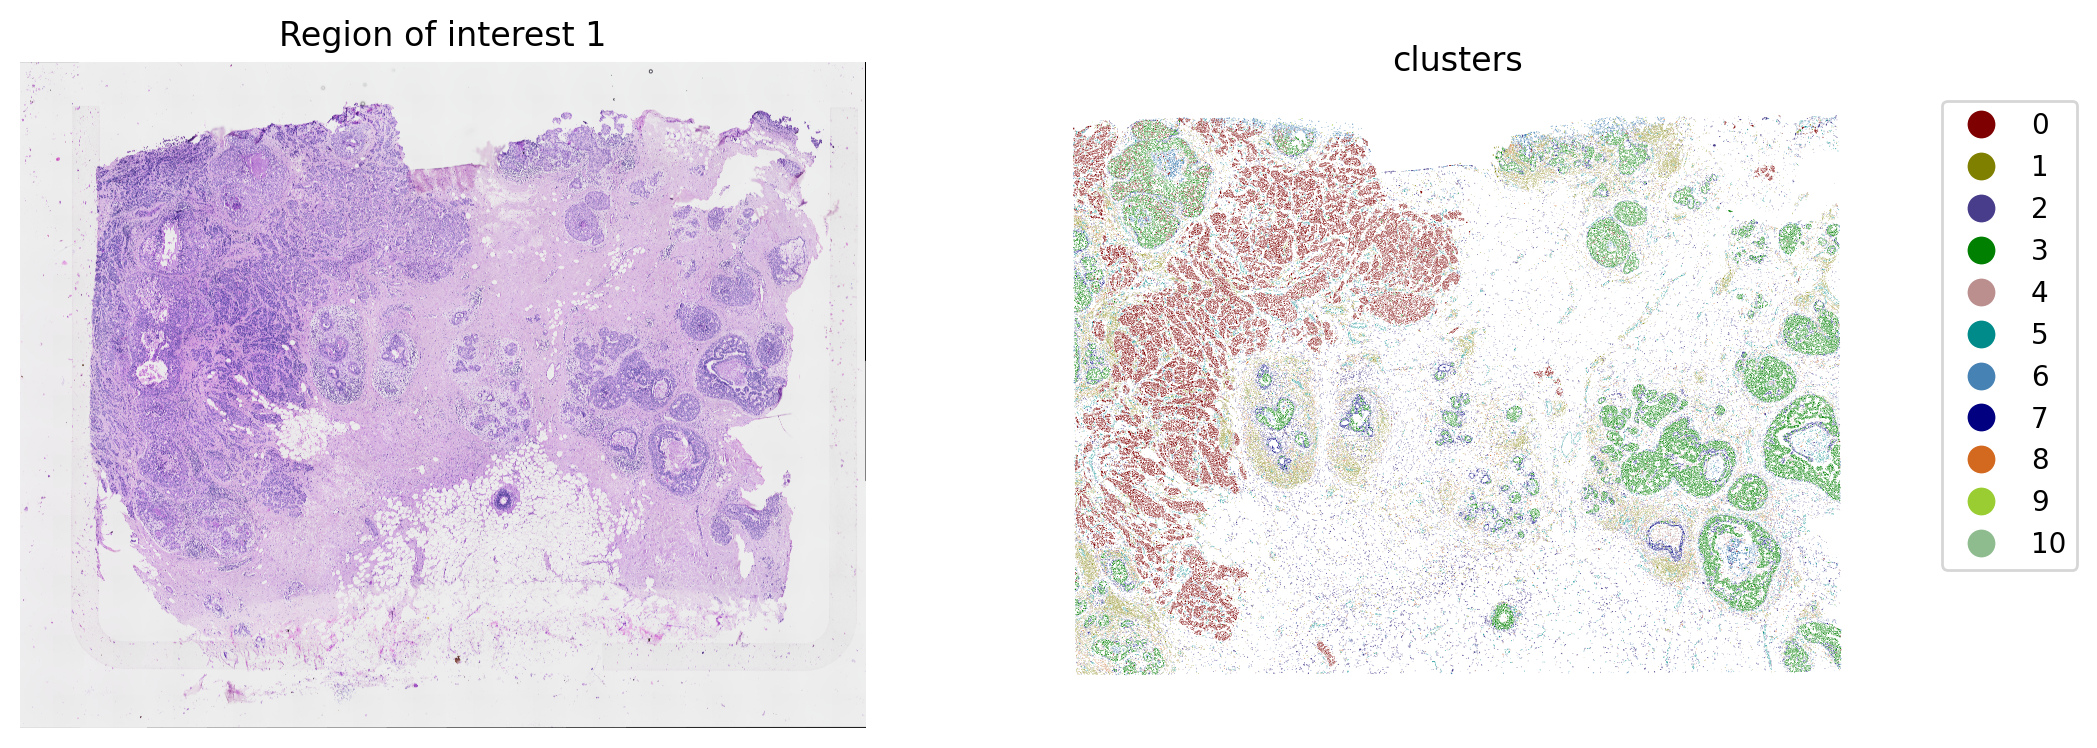

In [28]:
import sys
sys.path.append('../src/utils')
import os
import importlib
import image_plot_utils
importlib.reload(image_plot_utils)
from image_plot_utils import plot_clusters_and_save_image
# Plot and save the clustering results
plot_clusters_and_save_image(title="Region of interest 1", gdf=gdf, img=img, adata=count_area_filtered_adata, color_by_obs='clusters', output_name="image_clustering.ROI1.tiff")

In [27]:
merged_gdf = gdf.merge(count_area_filtered_adata.obs['clusters'].astype('category'), left_on='id', right_index=True)

<Axes: >

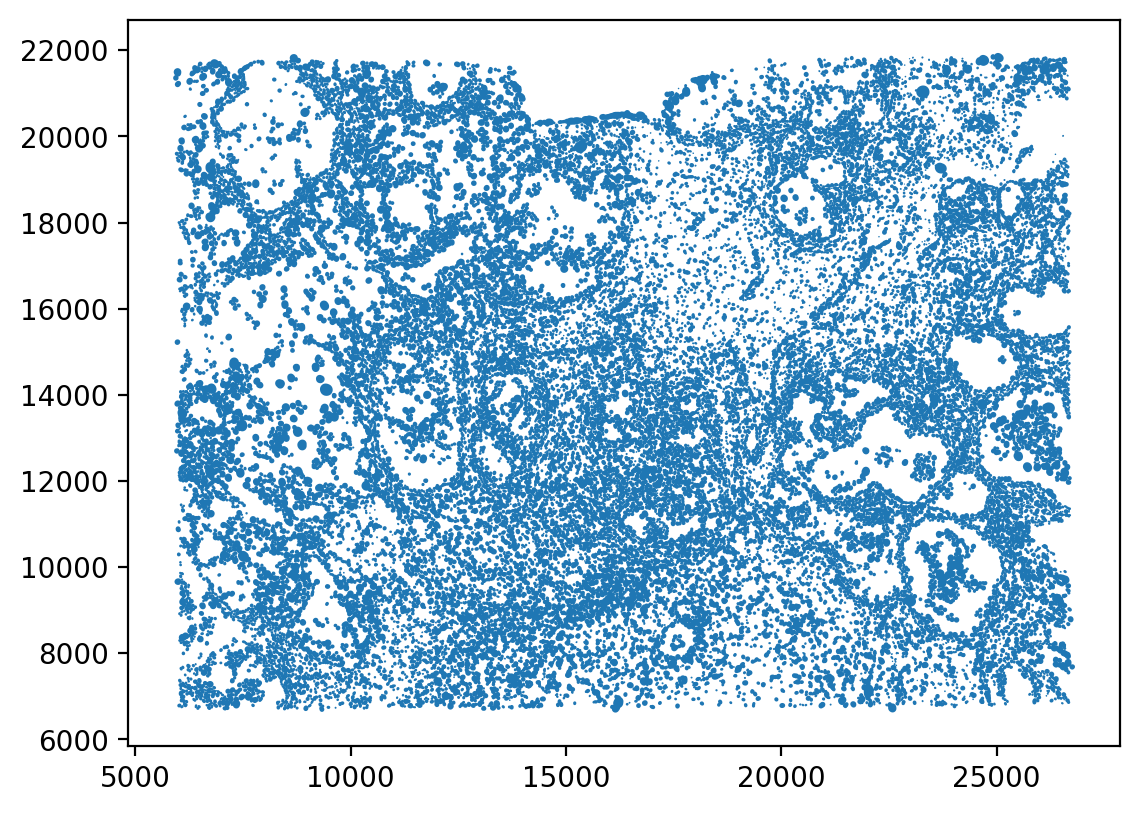

In [28]:
merged_gdf.plot()

In [29]:
merged_gdf_no_clusters = merged_gdf.drop(columns=['clusters'])

In [30]:
import sys
sys.path.append('../src/utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import load_dataframe

In [31]:
cells_data = load_dataframe('../data/xenium/outs/cells.parquet')

In [32]:
cells_data

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  
0        58.387031     26.642188  
1       197.016719     42.130781  
2        16.256250     12.688906  
3        42.311406     10.069844  
4       107.652500     37.479688  
...            ...           ...  
167775  220.452813     60.599688  
167776   37.389375     25.242344  
167777  287.058281     86.700000  
167778  235.354375     25.197188  
167779  270.079531    111.806875  

[167780 rows x 9 columns]

In [33]:
import numpy as np
transform_matrix = np.array([
    [1.7125010585876286, 0.008345081015717404, -10397.19948741904],
    [0.008345081015717404, -1.7125010585876286, 37211.538978661185],
    [0, 0, 1]
])

# Get the inverse matrix
transform_matrix_inv = np.linalg.inv(transform_matrix)

# Extract coordinates and apply scaling
coords = cells_data[['x_centroid', 'y_centroid']].values
micron_to_pixel = 0.2125  # Microns per pixel
coords_scaled = coords / micron_to_pixel

# Function to transform coordinates
def transform_coordinates(coords, transform_matrix):
    coords = np.hstack((coords, np.ones((len(coords), 1))))
    transformed_coords = np.dot(transform_matrix, coords.T).T
    # Return only the x and y coordinates
    return transformed_coords[:, :2]

# Apply the transformation to the scaled coordinates
transformed_coords = transform_coordinates(coords_scaled, transform_matrix_inv)

# Update the DataFrame with the transformed coordinates
cells_data[['x_location_transformed', 'y_location_transformed']] = transformed_coords

In [34]:
from shapely.geometry import Polygon, Point
# Create a GeoDataFrame from cells_data
geometry = [Point(xy) for xy in zip(cells_data['x_location_transformed'], cells_data['y_location_transformed'])]
cells_gdf = gpd.GeoDataFrame(cells_data, geometry=geometry)
cells_gdf.crs = None

In [35]:
cells_gdf

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  x_location_transformed   
0        58.387031     26.642188             8297.871957  \
1       197.016719     42.130781             8240.416393   
2        16.256250     12.688906             8302.087393   
3        42.311406     10.069844             8234.691783   
4       107.652500     37.479688             8281.733889   
...            ...           ...                     ...   
167775  220.452813     60.599688            26520.667780   
167776   37.389375     25.242344            26598.254969   
167777  287.058281     86.700000            26561.075074   
167778  235.354375     25.197188            26582.026307   
167779  270.079531    111.806875            26613.936167   

        y_location_transformed                    geometry  
0                 20873.427800  POINT (8297.872 20873.428)  
1                 20868.090296  POINT (8240.416 20868.090)  
2                 20858.192164  POINT (8302.087 20858.192)  
3                 20850.967862  POINT (8234.692 20850.968)  
4                 20856.720876  POINT (8281.734 20856.721)  
...                        ...                         ...  
167775             7803.121686  POINT (26520.668 7803.122)  
167776             7812.837128  POINT (26598.255 7812.837)  
167777             7791.621519  POINT (26561.075 7791.622)  
167778             7765.396076  POINT (26582.026 7765.396)  
167779             7780.706674  POINT (26613.936 7780.707)  

[167780 rows x 12 columns]

<Axes: >

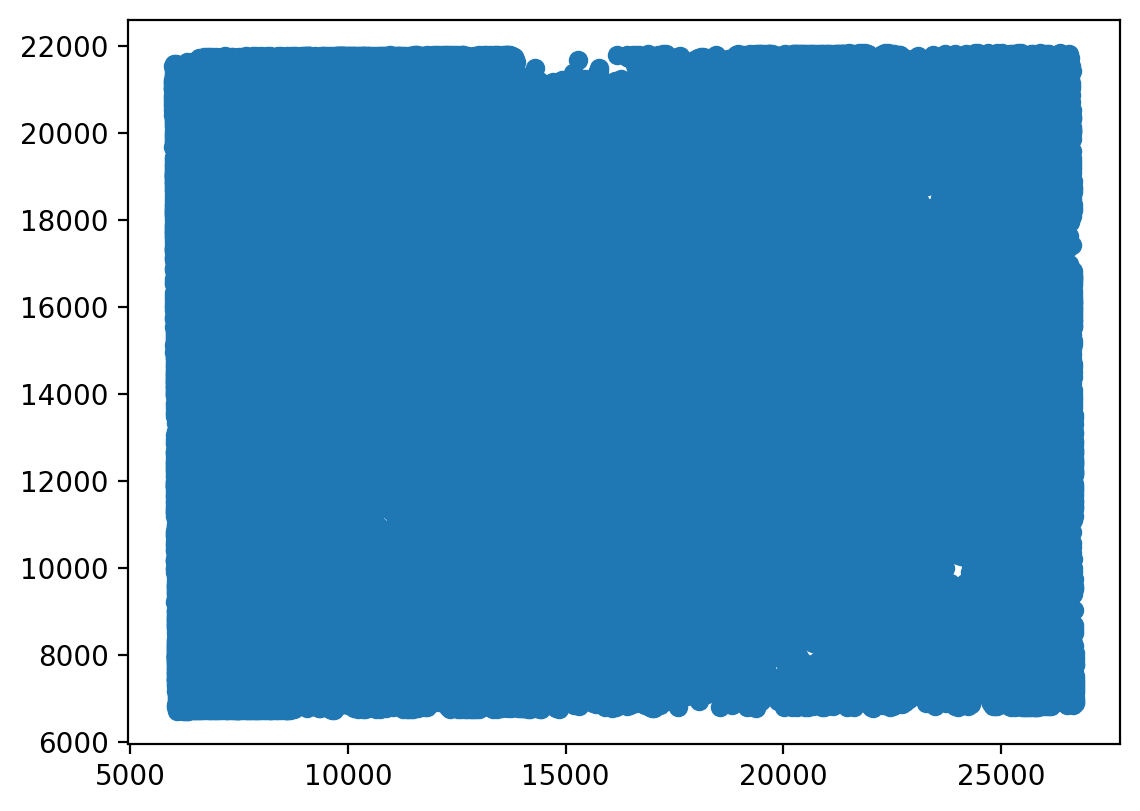

In [38]:
cells_gdf.plot()

In [36]:
# Perform spatial join
joined = gpd.sjoin(merged_gdf_no_clusters, cells_gdf, how='left', predicate='intersects')

<Axes: >

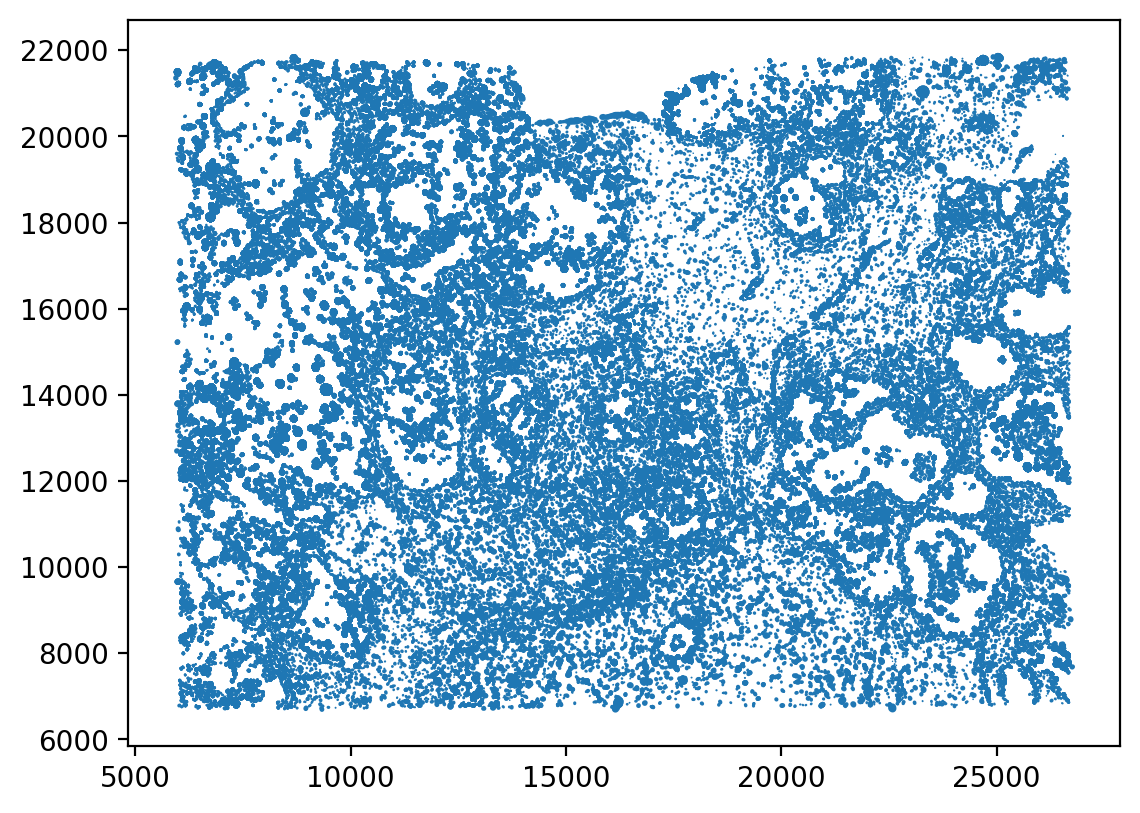

In [37]:
joined.plot()

In [38]:
joined

id                                           geometry   
6224      ID_6225  POLYGON ((7204.868 6830.683, 7204.620 6828.340...  \
6224      ID_6225  POLYGON ((7204.868 6830.683, 7204.620 6828.340...   
6224      ID_6225  POLYGON ((7204.868 6830.683, 7204.620 6828.340...   
6224      ID_6225  POLYGON ((7204.868 6830.683, 7204.620 6828.340...   
6224      ID_6225  POLYGON ((7204.868 6830.683, 7204.620 6828.340...   
...           ...                                                ...   
215201  ID_215202  POLYGON ((24576.018 21269.137, 24575.776 21270...   
215202  ID_215203  POLYGON ((25258.401 20784.955, 25258.409 20785...   
215203  ID_215204  POLYGON ((26368.296 21757.581, 26368.223 21757...   
215208  ID_215209  POLYGON ((26225.612 21355.425, 26226.876 21357...   
215217  ID_215218  POLYGON ((26620.011 21122.106, 26620.008 21122...   

        index_right  cell_id   x_centroid   y_centroid  transcript_counts   
6224        42285.0  42286.0   419.440396  5441.476294              146.0  \
6224        42275.0  42276.0   383.680734  5440.973682              434.0   
6224        42284.0  42285.0   399.355255  5437.458716              592.0   
6224        42280.0  42281.0   409.853253  5431.781812              120.0   
6224        42276.0  42277.0   388.584213  5427.913232               83.0   
...             ...      ...          ...          ...                ...   
215201          NaN      NaN          NaN          NaN                NaN   
215202          NaN      NaN          NaN          NaN                NaN   
215203      12243.0  12244.0  7433.772949    37.697025              220.0   
215208          NaN      NaN          NaN          NaN                NaN   
215217          NaN      NaN          NaN          NaN                NaN   

        control_probe_counts  control_codeword_counts  total_counts   
6224                     0.0                      0.0         146.0  \
6224                     0.0                      0.0         434.0   
6224                     0.0                      0.0         592.0   
6224                     0.0                      0.0         120.0   
6224                     0.0                      0.0          83.0   
...                      ...                      ...           ...   
215201                   NaN                      NaN           NaN   
215202                   NaN                      NaN           NaN   
215203                   0.0                      0.0         220.0   
215208                   NaN                      NaN           NaN   
215217                   NaN                      NaN           NaN   

         cell_area  nucleus_area  x_location_transformed   
6224    319.706250     33.822031             7190.766137  \
6224    317.132344     76.133437             7092.495663   
6224    398.142656    147.525469             7135.520510   
6224    101.466094     10.611719             7164.291874   
6224     48.362344     24.700469             7105.795014   
...            ...           ...                     ...   
215201         NaN           NaN                     NaN   
215202         NaN           NaN                     NaN   
215203  417.424375     21.133125            26393.045517   
215208         NaN           NaN                     NaN   
215217         NaN           NaN                     NaN   

        y_location_transformed  
6224               6811.440601  
6224               6812.342883  
6224               6822.211526  
6224               6837.951629  
6224               6848.297267  
...                        ...  
215201                     NaN  
215202                     NaN  
215203            21754.376810  
215208                     NaN  
215217                     NaN  

[115151 rows x 14 columns]

In [39]:
filtered_joined = joined[~joined['index_right'].isna()]

In [40]:
filtered_joined

id                                           geometry   
6224      ID_6225  POLYGON ((7204.868 6830.683, 7204.620 6828.340...  \
6224      ID_6225  POLYGON ((7204.868 6830.683, 7204.620 6828.340...   
6224      ID_6225  POLYGON ((7204.868 6830.683, 7204.620 6828.340...   
6224      ID_6225  POLYGON ((7204.868 6830.683, 7204.620 6828.340...   
6224      ID_6225  POLYGON ((7204.868 6830.683, 7204.620 6828.340...   
...           ...                                                ...   
215182  ID_215183  POLYGON ((26564.774 21243.534, 26564.078 21243...   
215194  ID_215195  POLYGON ((26470.877 21305.119, 26470.843 21305...   
215196  ID_215197  POLYGON ((26331.266 21734.520, 26330.946 21734...   
215196  ID_215197  POLYGON ((26331.266 21734.520, 26330.946 21734...   
215203  ID_215204  POLYGON ((26368.296 21757.581, 26368.223 21757...   

        index_right   cell_id   x_centroid   y_centroid  transcript_counts   
6224        42285.0   42286.0   419.440396  5441.476294              146.0  \
6224        42275.0   42276.0   383.680734  5440.973682              434.0   
6224        42284.0   42285.0   399.355255  5437.458716              592.0   
6224        42280.0   42281.0   409.853253  5431.781812              120.0   
6224        42276.0   42277.0   388.584213  5427.913232               83.0   
...             ...       ...          ...          ...                ...   
215182      13690.0   13691.0  7507.628320   220.222165              778.0   
215194     166599.0  166600.0  7475.431250   186.915993              504.0   
215196      12244.0   12245.0  7415.893066    41.193146              176.0   
215196      12242.0   12243.0  7417.128223    26.647450              269.0   
215203      12243.0   12244.0  7433.772949    37.697025              220.0   

        control_probe_counts  control_codeword_counts  total_counts   
6224                     0.0                      0.0         146.0  \
6224                     0.0                      0.0         434.0   
6224                     0.0                      0.0         592.0   
6224                     0.0                      0.0         120.0   
6224                     0.0                      0.0          83.0   
...                      ...                      ...           ...   
215182                   0.0                      0.0         778.0   
215194                   0.0                      0.0         505.0   
215196                   0.0                      0.0         176.0   
215196                   0.0                      0.0         269.0   
215203                   0.0                      0.0         220.0   

          cell_area  nucleus_area  x_location_transformed   
6224     319.706250     33.822031             7190.766137  \
6224     317.132344     76.133437             7092.495663   
6224     398.142656    147.525469             7135.520510   
6224     101.466094     10.611719             7164.291874   
6224      48.362344     24.700469             7105.795014   
...             ...           ...                     ...   
215182  1281.715000     90.673750            26598.436334   
215194   833.087656     31.202969            26509.516223   
215196   237.973438     11.514844            26343.960318   
215196   409.522031      8.037813            26347.159620   
215203   417.424375     21.133125            26393.045517   

        y_location_transformed  
6224               6811.440601  
6224               6812.342883  
6224               6822.211526  
6224               6837.951629  
6224               6848.297267  
...                        ...  
215182            21253.806123  
215194            21344.896799  
215196            21744.530421  
215196            21784.516984  
215203            21754.376810  

[111811 rows x 14 columns]

<Axes: >

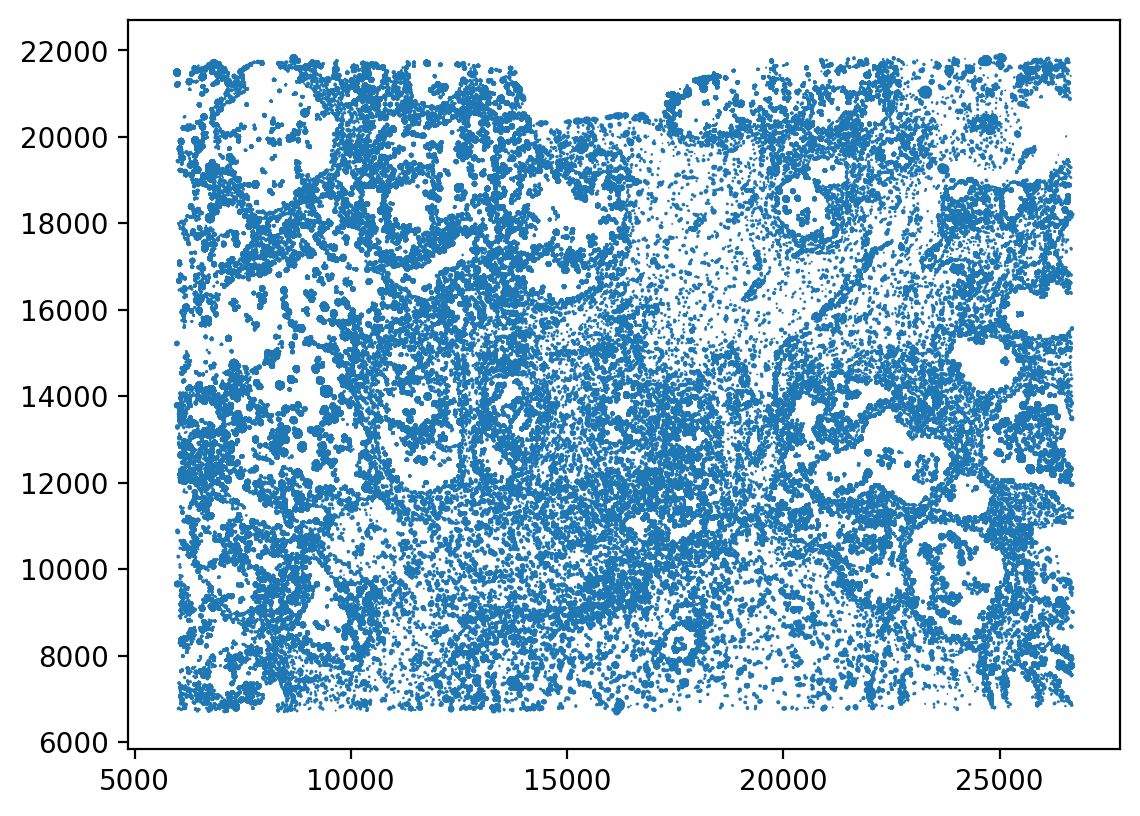

In [41]:
filtered_joined.plot()

In [42]:
import pandas as pd

# Group by 'id' and aggregate 'cell_id' by joining with a comma for duplicates
aggregated_df = filtered_joined.groupby('id').agg({
    'geometry': 'first',  # Keep the first geometry (assuming it's the same for duplicates)
    'cell_id': lambda x: ','.join(x.astype(str))  # Combine cell_id values with a comma
}).reset_index()

aggregated_df

id                                           geometry   
0      ID_100002  POLYGON ((23729.223 11038.876, 23728.927 11039...  \
1      ID_100003  POLYGON ((21748.234 10990.098, 21749.257 10991...   
2      ID_100012  POLYGON ((23844.211 13620.763, 23844.278 13620...   
3      ID_100014  POLYGON ((23288.749 13298.980, 23289.149 13299...   
4      ID_100015  POLYGON ((22484.358 11535.576, 22484.303 11535...   
...          ...                                                ...   
35257   ID_99960  POLYGON ((22414.899 10893.701, 22414.885 10894...   
35258   ID_99982  POLYGON ((23406.636 12626.449, 23405.909 12627...   
35259   ID_99985  POLYGON ((23296.354 13676.267, 23296.650 13676...   
35260   ID_99994  POLYGON ((23229.768 11608.214, 23230.095 11608...   
35261   ID_99996  POLYGON ((21762.545 11096.597, 21762.577 11097...   

                                                 cell_id  
0           144597.0,144576.0,144595.0,144585.0,144571.0  
1      131515.0,131514.0,131512.0,131511.0,131510.0,1...  
2                                               140584.0  
3                                      140227.0,141294.0  
4                                               145773.0  
...                                                  ...  
35257                                  146254.0,146234.0  
35258       140353.0,140352.0,140335.0,140337.0,140334.0  
35259                         140909.0,140907.0,140901.0  
35260                         144993.0,144987.0,144998.0  
35261                131498.0,131497.0,131496.0,131494.0  

[35262 rows x 3 columns]

In [43]:
# Count the number of cell_ids by splitting on the comma and checking the length
aggregated_df['cell_id_count'] = aggregated_df['cell_id'].apply(lambda x: len(x.split(',')))

# Filter the rows where the count of cell_ids is greater than 1
rows_with_multiple_cell_ids = aggregated_df[aggregated_df['cell_id_count'] > 1]

# Count how many such rows exist
num_rows_with_multiple_cell_ids = rows_with_multiple_cell_ids.shape[0]

# Display the result
print(f"Number of rows with more than one cell_id: {num_rows_with_multiple_cell_ids}")


Number of rows with more than one cell_id: 22325


In [44]:
filtered_df = aggregated_df[aggregated_df['cell_id_count'] <= 1]

# Drop the 'cell_id_count' column if you no longer need it
filtered_df = filtered_df.drop(columns=['cell_id_count'])

# Display the resulting DataFrame
filtered_df

id                                           geometry   cell_id
2      ID_100012  POLYGON ((23844.211 13620.763, 23844.278 13620...  140584.0
4      ID_100015  POLYGON ((22484.358 11535.576, 22484.303 11535...  145773.0
5      ID_100031  POLYGON ((23949.109 13863.701, 23949.079 13863...  140869.0
6      ID_100036  POLYGON ((22455.006 12460.010, 22454.671 12460...  146804.0
9      ID_100072  POLYGON ((22615.158 11568.777, 22614.705 11569...  145768.0
...          ...                                                ...       ...
35239   ID_99820  POLYGON ((23758.063 12122.381, 23758.064 12122...  144020.0
35240   ID_99850  POLYGON ((23311.534 12531.208, 23311.565 12531...  145869.0
35244   ID_99881  POLYGON ((22372.536 11575.544, 22372.509 11575...  146361.0
35253   ID_99926  POLYGON ((21610.703 12947.806, 21610.712 12947...  127897.0
35256   ID_99957  POLYGON ((23875.219 12265.507, 23875.272 12265...  144234.0

[12937 rows x 3 columns]

In [45]:
filtered_gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')

<Axes: >

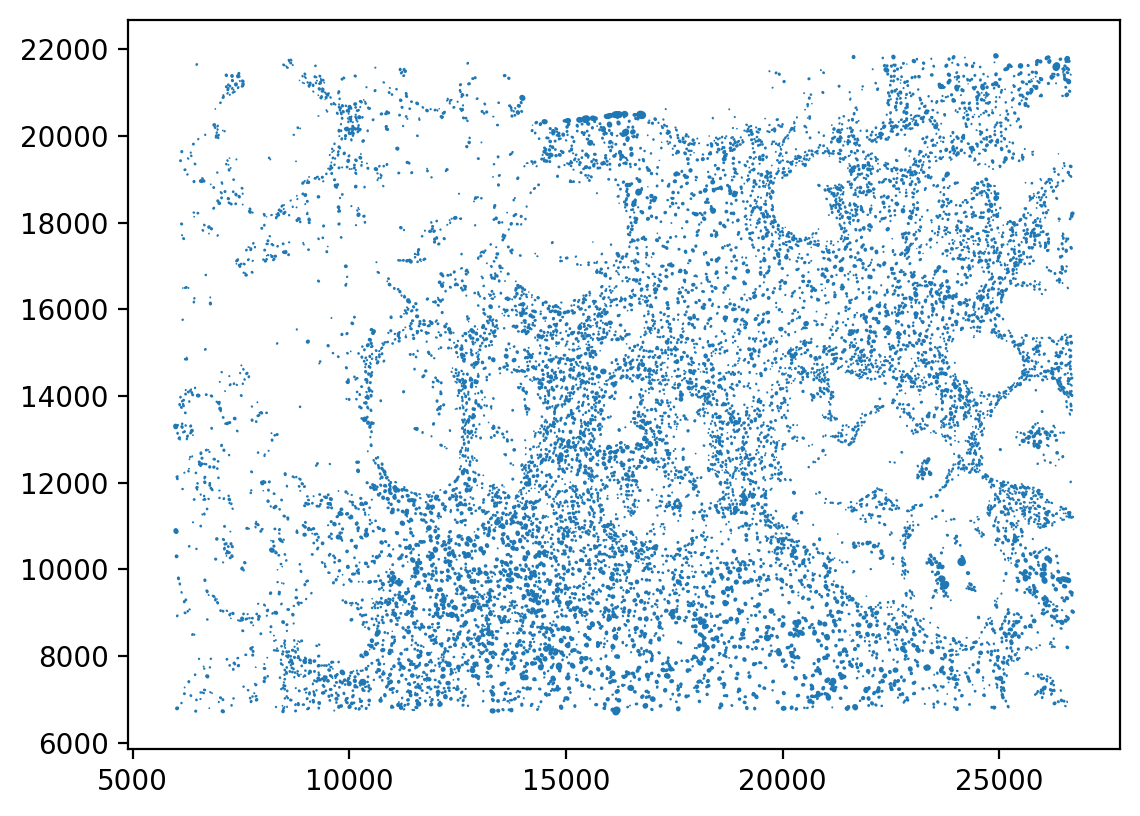

In [46]:
filtered_gdf.plot()

In [47]:
# important use as gdf for id mapping
filtered_gdf.to_file("../data/xenium/outs/final_adatas/filtered_gdf_stardist_buffered07.geojson", driver='GeoJSON')

In [48]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 38602 × 541
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [49]:
import anndata as ad

# Extract the ids from filtered_gdf
valid_ids = filtered_gdf['id'].tolist()

# Filter the rows in grouped_filtered_adata based on the valid ids
filtered_grouped_adata = grouped_filtered_adata[grouped_filtered_adata.obs['id'].isin(valid_ids)]


In [50]:
filtered_grouped_adata

View of AnnData object with n_obs × n_vars = 12937 × 541
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [51]:
filtered_grouped_adata.write("../data/xenium/improved_outs/grouped_filtered_stardist_buffered07_adata.h5ad")
# IMPORTANT you will need this as ADATA